In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import os
import pickle

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

In [3]:
import eif

In [4]:
random.seed(42)
np.random.seed(42)

## Data Preparation

- Load the data

In [5]:
df = pd.read_parquet('OLDTv3 Datasets')
df.set_index('hashed_tln', inplace=True)

df.head()

,META_for_month,is_impacted,1_total_P,1_total_Q,1_total_KC,1_total_CC,1_total_KC_per_day,1_total_S,1_max_P,1_min_P,...,weather_sum10_heatindex_12pm_pressure,weather_sum10_heatindex_12pm_cloudcover,weather_sum10_heatindex_12pm_HeatIndexC,weather_sum10_heatindex_12pm_WindChillC,total_P,total_Q,total_KC,total_CC,total_KC_per_day,total_S
hashed_tln,,,,,,,,,,,,,,,,,,,,,
4534789187331872806,2020-09,0,1316.754028,645.172974,1001.0,3.000000,32.290321,1466.318359,665.301025,18.938999,...,10090.0,238.0,396.0,335.0,1280.036042,627.182001,941.0,3.000000,31.366666,1425.429565
-8784325762925109637,2021-01,0,2252.943115,1103.880981,2134.0,10.160000,68.838715,2508.845459,917.642029,82.764000,...,10106.0,447.0,342.0,305.0,2022.800987,991.116993,1617.0,10.160000,52.161290,2252.562256
-3488696552317893546,2020-12,0,14301.871094,7007.523926,10366.0,43.049999,345.533325,15926.358398,2906.989990,0.000000,...,10100.0,298.0,363.0,317.0,14077.274963,6897.480029,9776.0,43.050000,315.354839,15676.252930
9097892585216145639,2020-12,0,18760.558594,9192.159180,14890.0,45.320000,496.333313,20891.490234,4774.932129,89.026001,...,10100.0,298.0,363.0,317.0,18409.270348,9020.040039,12748.0,45.320000,411.225811,20500.300781
6405709742834628611,2020-04,0,8687.954102,4256.860840,5666.0,88.919998,182.774200,9674.782227,2220.969971,5.009000,...,10121.0,222.0,386.0,340.0,8650.271070,4238.395975,6120.0,88.919999,204.000001,9632.818359


- Remove CO, META_for_month, Weather
- FillNA with 0

In [6]:
data = df.drop([c for c in df.columns if 'weather' in c], axis=1)


In [7]:
data.fillna(data.mean(),inplace=True)

In [8]:
data.count().isnull()

META_for_month      False
is_impacted         False
1_total_P           False
1_total_Q           False
1_total_KC          False
                    ...  
total_Q             False
total_KC            False
total_CC            False
total_KC_per_day    False
total_S             False
Length: 524, dtype: bool

## Split dataframes by year 2020 and 2021

In [9]:
df1 = data[data['META_for_month'] <= '2020-12']
print(df1)

                     META_for_month  is_impacted     1_total_P     1_total_Q  \
hashed_tln                                                                     
4534789187331872806         2020-09            0   1316.754028    645.172974   
-3488696552317893546        2020-12            0  14301.871094   7007.523926   
9097892585216145639         2020-12            0  18760.558594   9192.159180   
6405709742834628611         2020-04            0   8687.954102   4256.860840   
6405709742834628611         2020-10            0   7917.811035   3879.510010   
...                             ...          ...           ...           ...   
-4253228264645747286        2020-11            0   3025.643066   1482.483032   
-3241915922368082053        2020-04            0   7741.348145   5810.564941   
-6112154507571650299        2020-07            0   2133.650146   1045.430054   
-3283261322135907284        2020-04            0   5082.576172   2490.320068   
-5202372100688753902        2020-03     

In [10]:
df2 = data[data['META_for_month'] >= '2021-01']
print(df2)

                     META_for_month  is_impacted     1_total_P     1_total_Q  \
hashed_tln                                                                     
-8784325762925109637        2021-01            0   2252.943115   1103.880981   
7418352048354131283         2021-01            0  31046.421875  15211.903320   
8916298948368098698         2021-02            0   5893.199707   2887.506104   
-7851381369700126444        2021-02            0  34799.750000   4374.969238   
6817948976443589203         2021-01            0  17051.699219   8354.865234   
...                             ...          ...           ...           ...   
4050269268982024314         2021-02            0   3190.730957   1563.369995   
1483199892431355253         2021-03            0   9788.250977   4795.975586   
-7371851919761512748        2021-01            0  12463.164062   6106.608887   
2016640256515698290         2021-02            0   2695.545898   1320.744019   
-691718465068812655         2021-02     

In [11]:
df1.drop('META_for_month', axis=1, inplace=True)
df2.drop('META_for_month', axis=1, inplace=True)

C:\Users\Sydney Nicole Calo\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Train-Val-Test Split

In [12]:
RANDOM_SEED = 42

Original Split

In [13]:
def getCounts(df, col='is_impacted'):
    df_counts = df[col].value_counts().to_frame()
    df_counts['pct'] = df[col].value_counts(normalize=True)
    return df_counts

In [14]:
getCounts(data)

,is_impacted,pct
0,218522,0.977272
1,5082,0.022728


In [62]:
impacted = df1[df1.is_impacted==1]
not_impacted  = df1[df1.is_impacted==0]

In [16]:
# split the impacted data, 50-50 
#impacted_val, impacted_test = train_test_split(impacted,
                                               #test_size=0.5,
                                               #shuffle=True,
                                               #random_state=RANDOM_SEED)

In [2]:
# split the not_impacted data, the test+val size is equal to the count of impacted
train, val = train_test_split(df1,
                                                        test_size=0.4,
                                                        shuffle =True,
                                                        random_state=RANDOM_SEED, stratify=impacted)
# split not_impacted_val to get a test set
# val, test = train_test_split(val,
                                                     #  test_size=0.5,
                                                     #  shuffle=True,
                                                     # random_state=RANDOM_SEED)

NameError: name 'train_test_split' is not defined

In [18]:
# combine the impacted and not_impacted data
#train_data = not_impacted_train
#val_data = impacted_val.append(not_impacted_val)
#test_data = impacted_test.append(not_impacted_test)

New Splits

In [19]:
getCounts(train)

,is_impacted,pct
0,100745,0.970494
1,3063,0.029506


In [20]:
getCounts(val)

,is_impacted,pct
0,67203,0.971057
1,2003,0.028943


In [21]:
#getCounts(test)

Separate the Features and Target variables

In [22]:
X_train = train.drop('is_impacted', axis=1)
y_train = train['is_impacted']

X_val = val.drop('is_impacted', axis=1)
y_val = val['is_impacted']

X_test = df2.drop('is_impacted', axis=1)
y_test = df2['is_impacted']

## Modelling

Scale and Apply PCA

In [23]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)

In [24]:
def get_min_pcs(X, n=0.99):
    
    pca = PCA(svd_solver='full')
    new_X2 = pca.fit_transform(X)
    
    var_explained = pca.explained_variance_ratio_
    
    fig, ax = plt.subplots(1, 2, figsize=(16,6))
    ax[0].plot(np.arange(1, len(var_explained)+1), var_explained)
    ax[0].set_xlabel('PC')
    ax[0].set_ylabel('variance explained')
    
    cum_var_explained = var_explained.cumsum()
    ax[1].plot(np.arange(1, len(cum_var_explained)+1),
                  cum_var_explained, '-o')
    ax[1].set_ylim(bottom=0)
    ax[1].set_xlabel('PC')
    ax[1].set_ylabel('cumulative variance explained');
    
    return np.searchsorted(cum_var_explained, n) + 1

42


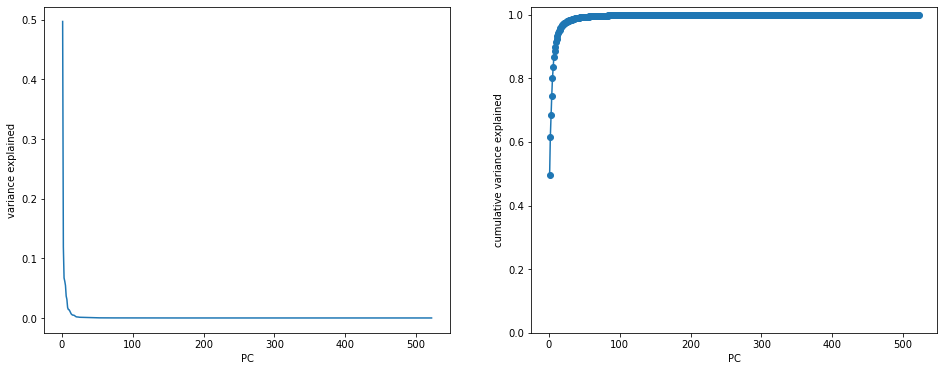

In [25]:
min_pcs = get_min_pcs(X_train_scaled)
print(min_pcs)

In [26]:
pca = PCA(n_components=min_pcs, svd_solver='full')
X_train_pca = pca.fit_transform(X_train_scaled)

### One Class SVM

Helper Functions

In [27]:
def plotConfMat(clf, X, y, **kwargs):
    y_pred = clf.predict(X)
    
    # map predictions to 0, 1
    if 'mapper' in kwargs:
        y_pred = kwargs['mapper'](y_pred)
    
    # plot the confusion matrix
    confmat = confusion_matrix(y_true=y, y_pred=y_pred)
    
    fig, ax = plt.subplots(figsize=(4,4))
    ax.matshow(confmat, cmap='Blues', alpha=0.3)
    
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Actual Label')
    ax.grid(False)
    ax.vlines(x=0.5, ymin=-0.5, ymax=1.5, color=(0.8, 0.8, 0.8))
    ax.hlines(y=0.5, xmin=-0.5, xmax=1.5, color=(0.8, 0.8, 0.8))
    
    # design
    if 'title' in kwargs:
        fig.suptitle(kwargs['title'], )
        print(kwargs['title'])
        
    if 'ticklabels' in kwargs:
        ticklabels = kwargs['ticklabels']
        ax.set_xticklabels(['']+ticklabels)
        ax.set_yticklabels(['']+ticklabels)
        print(classification_report(y, y_pred, target_names=kwargs['ticklabels']))
    else:
        print(classification_report(y, y_pred))

    plt.tight_layout()
    
    return fig

In [28]:
def mapPreds(x):
    if x == -1:
        return 1
    elif x == 1:
        return 0
    else:
        return x
    
mapPreds = np.vectorize(mapPreds)

In [29]:
clf_svm = OneClassSVM(gamma='scale', nu=0.05, verbose=True)
svm_model = Pipeline([('scaler', scaler), ('pca', pca), ('clf', clf_svm)], verbose=True)
svm_model.fit(X_train)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   1.1s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   6.7s
[LibSVM][Pipeline] ............... (step 3 of 3) Processing clf, total= 2.1min


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=42, svd_solver='full')),
                ('clf', OneClassSVM(nu=0.05, verbose=True))],
         verbose=True)

OneClassSVM Validation Set
              precision    recall  f1-score   support

Not Impacted       0.97      0.95      0.96     67203
    Impacted       0.01      0.02      0.02      2003

    accuracy                           0.92     69206
   macro avg       0.49      0.49      0.49     69206
weighted avg       0.94      0.92      0.93     69206



<ipython-input-27-ff37b61e544b>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+ticklabels)
<ipython-input-27-ff37b61e544b>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+ticklabels)


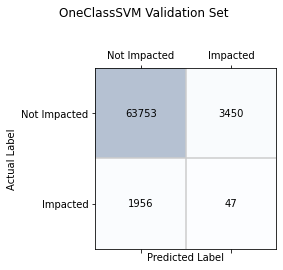

In [30]:
# plotConfMat(svm_model, X_train, y_train, title='OneClassSVM Train Set')
plotConfMat(svm_model, X_val, y_val,
            title='OneClassSVM Validation Set', mapper=mapPreds,
            ticklabels=['Not Impacted', 'Impacted']);

In [31]:
os.makedirs('models', exist_ok=True)

with open('models/oneClassSVM.pkl', 'wb') as fp:
    pickle.dump(svm_model, fp)

### Isolation Forest

In [32]:
iso_forest = IsolationForest(random_state=RANDOM_SEED, contamination=0.03, n_jobs=-1, verbose=True)
if_model = Pipeline([('scaler', scaler), ('pca', pca), ('clf', iso_forest)], verbose=True)
if_model.fit(X_train)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.9s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   6.3s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.3s remaining:    7.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished


[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.7s


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=42, svd_solver='full')),
                ('clf',
                 IsolationForest(contamination=0.03, n_jobs=-1, random_state=42,
                                 verbose=True))],
         verbose=True)

In [33]:
with open('models/iso_forest.pkl', 'wb') as fp:
    pickle.dump(if_model, fp)

Isolation Forest Validation Set
              precision    recall  f1-score   support

Not Impacted       0.97      0.97      0.97     67203
    Impacted       0.03      0.03      0.03      2003

    accuracy                           0.94     69206
   macro avg       0.50      0.50      0.50     69206
weighted avg       0.94      0.94      0.94     69206



<ipython-input-27-ff37b61e544b>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+ticklabels)
<ipython-input-27-ff37b61e544b>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+ticklabels)


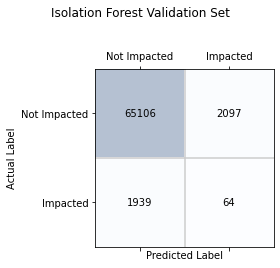

In [34]:
plotConfMat(if_model, X_val, y_val,
            title='Isolation Forest Validation Set', mapper=mapPreds,
            ticklabels=['Not Impacted', 'Impacted']);
plt.tight_layout()

### Extended Isolation Forest Level 1

In [35]:
ext_iso_forest_lvl1 = eif.iForest(X_train.values, ntrees=100, sample_size=256, ExtensionLevel=1)

We define the threshold using the anomaly scores

In [36]:
anomaly_scores = ext_iso_forest_lvl1.compute_paths(X_in=X_val.values)

In [37]:
df_yval = y_val.to_frame()
df_yval['anomaly_score_pred'] = anomaly_scores
df_yval.head()

,is_impacted,anomaly_score_pred
hashed_tln,,
5961337880800722726,0,0.450206
6564307778821366612,0,0.338632
1850444711819560735,0,0.366833
7474736983091275635,0,0.610659
-2356614864082428741,0,0.314112


Since EIF does not return a prediction, we create our own threshold using the validation set

We scale the anomaly scores using y_val (sklearn precision_recall_curve accepts 0-1 range) then plot the precision-recall curve to get the threshold

In [38]:
yval_scaler = MinMaxScaler()

yval_anomaly_scaled = yval_scaler.fit_transform(df_yval.anomaly_score_pred.values.reshape(-1, 1))

In [39]:
df_yval['impacted_proba'] = yval_anomaly_scaled
df_yval['not_impacted_proba'] = 1-yval_anomaly_scaled

In [40]:
p, r, t = precision_recall_curve(y_true=df_yval.is_impacted, probas_pred=df_yval['impacted_proba'])

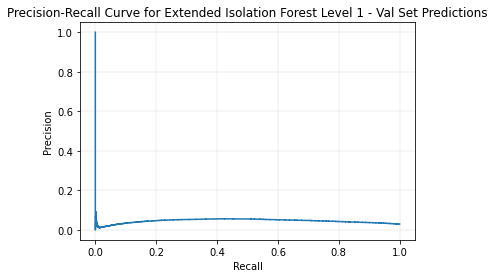

In [41]:
fig, ax = plt.subplots()

ax.step(x=r, y=p)
ax.set_facecolor('white')
ax.set(xlabel='Recall',
       ylabel='Precision',
       title='Precision-Recall Curve for Extended Isolation Forest Level 1 - Val Set Predictions')

ax.grid(True, linewidth=0.2)

inverse transform the threshold

In [42]:
thresh_idx = np.argmax(p[:-203])
print(f'Optimal Precision {p[thresh_idx]:.02%}')
print(f'Recall @ Optimal Precision {r[thresh_idx]:.02%}')

anomaly_thresh = yval_scaler.inverse_transform(np.array(t[thresh_idx]).reshape(1,-1))
print(f'Anomaly Score Threshold {anomaly_thresh[0,0]:.04f}')

Optimal Precision 5.65%
Recall @ Optimal Precision 42.19%
Anomaly Score Threshold 0.3752


Plot Threshold for Optimal Precision

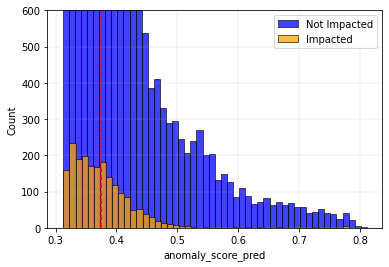

In [43]:
fig, ax = plt.subplots()

sns.histplot(data=df_yval.loc[df_yval.is_impacted==0, 'anomaly_score_pred'],
             ax=ax,
             color='blue',
             binwidth=0.01,
             label='Not Impacted')
sns.histplot(data=df_yval.loc[df_yval.is_impacted==1, 'anomaly_score_pred'],
             ax=ax, color='orange',
             binwidth=0.01,
             label='Impacted')
ax.vlines(x=anomaly_thresh[0,0], ymin=0, ymax=600, ls='--', colors='red')
ax.set_ylim(0, 600)
ax.grid(lw=0.2)
ax.legend(facecolor='white')
ax.set_facecolor('white')

For Threshold at Max Precision

In [44]:
df_yval['y_pred'] = df_yval.anomaly_score_pred.apply(lambda x: 1 if x > anomaly_thresh else 0)

In [45]:
def plotConfMat_EIF(y_true, y_pred, **kwargs):
    # plot the confusion matrix
    confmat = confusion_matrix(y_true=y_true, y_pred=y_pred)
    
    fig, ax = plt.subplots(figsize=(4,4))
    ax.matshow(confmat, cmap='Blues', alpha=0.3)
    
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Actual Label')
    ax.grid(False)
    ax.vlines(x=0.5, ymin=-0.5, ymax=1.5, color=(0.8, 0.8, 0.8))
    ax.hlines(y=0.5, xmin=-0.5, xmax=1.5, color=(0.8, 0.8, 0.8))
    
    # design
    if 'title' in kwargs:
        fig.suptitle(kwargs['title'], )
        print(kwargs['title'])
        
    if 'ticklabels' in kwargs:
        ticklabels = kwargs['ticklabels']
        ax.set_xticklabels(['']+ticklabels)
        ax.set_yticklabels(['']+ticklabels)
        print(classification_report(y_true, y_pred, target_names=kwargs['ticklabels']))
    else:
        print(classification_report(y_true, y_pred))

    plt.tight_layout()
    
    return fig

Extended Isolation Forest Level 1 Validation Set - Max Precision
              precision    recall  f1-score   support

Not Impacted       0.98      0.79      0.87     67203
    Impacted       0.06      0.42      0.10      2003

    accuracy                           0.78     69206
   macro avg       0.52      0.61      0.49     69206
weighted avg       0.95      0.78      0.85     69206



<ipython-input-45-4c813d9954a3>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+ticklabels)
<ipython-input-45-4c813d9954a3>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+ticklabels)


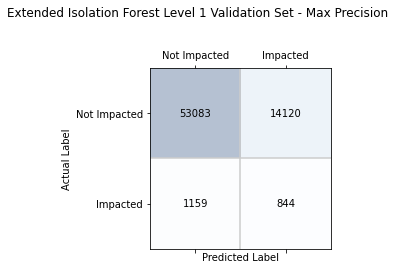

In [46]:
plotConfMat_EIF(df_yval.is_impacted, df_yval.y_pred, 
                title='Extended Isolation Forest Level 1 Validation Set - Max Precision', 
                ticklabels=['Not Impacted', 'Impacted']);

In [47]:
with open('models/extended_isoForest_1_p.pkl', 'wb') as fp:
    pickle.dump({'model':ext_iso_forest_lvl1, 'threshold':anomaly_thresh[0,0]}, fp)

In [48]:
#with open('models/extended_isoForest_1_r.pkl', 'wb') as fp:
   # pickle.dump({'model':ext_iso_forest_lvl1, 'threshold':anomaly_thresh_r[0,0]}, fp)

**Predict on the Test Set**

- We can now use the threshold taken above, no need to scale the anomaly scores

For Threshold at Optimal Precision

In [49]:
df_ytest = y_test.to_frame()

test_anomaly_scores = ext_iso_forest_lvl1.compute_paths(X_in=X_test.values)

df_ytest['anomaly_score_pred'] = test_anomaly_scores
df_ytest['y_pred'] = df_ytest.anomaly_score_pred.apply(lambda x: 1 if x > anomaly_thresh else 0)

Extended Isolation Forest Level 1 Test Set - Max Precision
              precision    recall  f1-score   support

Not Impacted       1.00      0.77      0.87     50574
    Impacted       0.00      0.38      0.00        16

    accuracy                           0.77     50590
   macro avg       0.50      0.57      0.44     50590
weighted avg       1.00      0.77      0.87     50590



<ipython-input-45-4c813d9954a3>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+ticklabels)
<ipython-input-45-4c813d9954a3>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+ticklabels)


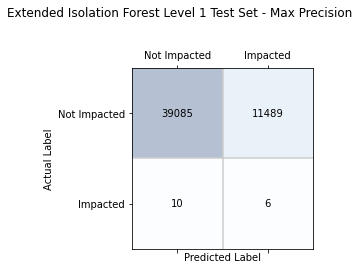

In [50]:
plotConfMat_EIF(df_ytest.is_impacted, df_ytest.y_pred, 
                title='Extended Isolation Forest Level 1 Test Set - Max Precision', 
                ticklabels=['Not Impacted', 'Impacted']);

**Extended Isolation Forest Max Extended Level**

In [51]:
ext_iso_forest_maxLvl = eif.iForest(X_train.values, ntrees=100, sample_size=256, ExtensionLevel=min_pcs-1)

In [52]:
anomaly_scores = ext_iso_forest_maxLvl.compute_paths(X_in=X_val.values)

df_yval = y_val.to_frame()
df_yval['anomaly_score_pred'] = anomaly_scores
df_yval.head()

,is_impacted,anomaly_score_pred
hashed_tln,,
5961337880800722726,0,0.447318
6564307778821366612,0,0.312295
1850444711819560735,0,0.342630
7474736983091275635,0,0.687563
-2356614864082428741,0,0.310980


In [53]:
yval_scaler = MinMaxScaler()

yval_anomaly_scaled = yval_scaler.fit_transform(df_yval.anomaly_score_pred.values.reshape(-1, 1))

df_yval['impacted_proba'] = yval_anomaly_scaled
df_yval['not_impacted_proba'] = 1-yval_anomaly_scaled

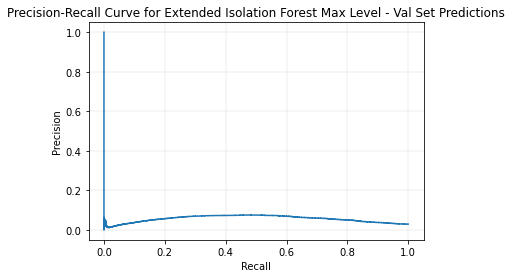

In [54]:
p, r, t = precision_recall_curve(y_true=df_yval.is_impacted, probas_pred=df_yval['impacted_proba'])

fig, ax = plt.subplots()

ax.step(x=r, y=p)
ax.set_facecolor('white')
ax.set(xlabel='Recall',
       ylabel='Precision',
       title='Precision-Recall Curve for Extended Isolation Forest Max Level - Val Set Predictions')

ax.grid(True, linewidth=0.2)

inverse transform the threshold

In [55]:
thresh_idx = np.argmax(p[:-228])
print(f'Optimal Precision {p[thresh_idx]:.02%}')
print(f'Recall @ Optimal Precision {r[thresh_idx]:.02%}')

anomaly_thresh = yval_scaler.inverse_transform(np.array(t[thresh_idx]).reshape(1,-1))
print(f'Anomaly Score Threshold {anomaly_thresh[0,0]:.04f}')

Optimal Precision 7.56%
Recall @ Optimal Precision 47.38%
Anomaly Score Threshold 0.3564


Plot Threshold for Optimal Precision

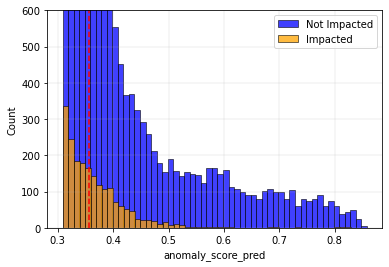

In [56]:
fig, ax = plt.subplots()

sns.histplot(data=df_yval.loc[df_yval.is_impacted==0, 'anomaly_score_pred'],
             ax=ax,
             color='blue',
             binwidth=0.01,
             label='Not Impacted')
sns.histplot(data=df_yval.loc[df_yval.is_impacted==1, 'anomaly_score_pred'],
             ax=ax, color='orange',
             binwidth=0.01,
             label='Impacted')
ax.vlines(x=anomaly_thresh[0,0], ymin=0, ymax=600, ls='--', colors='red')
ax.set_ylim(0, 600)
ax.grid(lw=0.2)
ax.legend(facecolor='white')
ax.set_facecolor('white')

For Threshold at Optimal Precision

<ipython-input-45-4c813d9954a3>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+ticklabels)
<ipython-input-45-4c813d9954a3>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+ticklabels)


Extended Isolation Forest Max Level Validation Set - Max Precision
              precision    recall  f1-score   support

Not Impacted       0.98      0.83      0.90     67203
    Impacted       0.08      0.47      0.13      2003

    accuracy                           0.82     69206
   macro avg       0.53      0.65      0.51     69206
weighted avg       0.96      0.82      0.88     69206



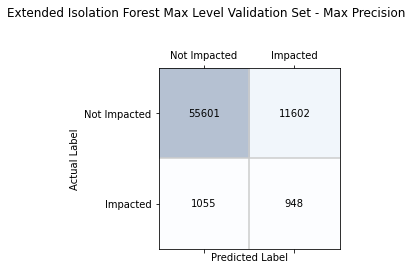

In [57]:
df_yval['y_pred'] = df_yval.anomaly_score_pred.apply(lambda x: 1 if x > anomaly_thresh else 0)

plotConfMat_EIF(df_yval.is_impacted, df_yval.y_pred, 
                title='Extended Isolation Forest Max Level Validation Set - Max Precision', 
                ticklabels=['Not Impacted', 'Impacted']);

In [58]:
#with open('models/extended_isoForest_max_p.pkl', 'wb') as fp:
   # pickle.dump({'model':ext_iso_forest_maxLvl, 'threshold':anomaly_thresh[0,0]}, fp)

In [59]:
#with open('models/extended_isoForest_max_r.pkl', 'wb') as fp:
  #  pickle.dump({'model':ext_iso_forest_maxLvl, 'threshold':anomaly_thresh_r[0,0]}, fp)

**Predict on Test Set**

For Threshold at Optimal Precision

In [60]:
df_ytest = y_test.to_frame()

test_anomaly_scores = ext_iso_forest_maxLvl.compute_paths(X_in=X_test.values)

df_ytest['anomaly_score_pred'] = test_anomaly_scores
df_ytest['y_pred'] = df_ytest.anomaly_score_pred.apply(lambda x: 1 if x > anomaly_thresh else 0)

Extended Isolation Forest Max Level Test Set - Max Precision
              precision    recall  f1-score   support

Not Impacted       1.00      0.84      0.91     50574
    Impacted       0.00      0.31      0.00        16

    accuracy                           0.84     50590
   macro avg       0.50      0.57      0.46     50590
weighted avg       1.00      0.84      0.91     50590



<ipython-input-45-4c813d9954a3>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+ticklabels)
<ipython-input-45-4c813d9954a3>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+ticklabels)


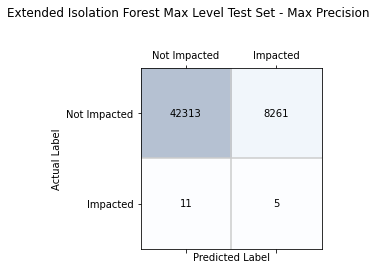

In [61]:
plotConfMat_EIF(df_ytest.is_impacted, df_ytest.y_pred, 
                title='Extended Isolation Forest Max Level Test Set - Max Precision', 
                ticklabels=['Not Impacted', 'Impacted']);